In [1]:
import torch
from src.vit import VitDetector
from src.loader import AirPlaneData, I_SIZE
from src.utils import make_grid_with_boxes

import albumentations as A
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
MODEL_SAVE_PATH = "models/model_vit.pth"

In [3]:
train_transform = A.Compose([
    A.Resize(I_SIZE, I_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Affine(
        scale=(0.95, 1.05),
        translate_percent=(0.05, 0.05),
        rotate=(-10, 10),
        shear=0,
        border_mode=0,
        p=0.5
    ),
    A.ColorJitter(p=0.5),
    A.MotionBlur(p=0.2),
    A.Normalize(mean=(0,0,0), std=(1.0,1.0,1.0)),
    A.pytorch.ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

test_transform = A.Compose([
    A.Resize(I_SIZE, I_SIZE),
    A.Normalize(mean=(0,0,0), std=(1.0,1.0,1.0)),
    A.pytorch.ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [4]:
air_plane_data = AirPlaneData(train_txt="database/train.txt", test_txt="database/test.txt")
_, test_loader = air_plane_data(batch_size=BATCH_SIZE, train_transf=train_transform, test_transf=test_transform)

In [5]:
# --------------PATCHES---------------
img_size = I_SIZE
patch_size = 16
n_patches = (img_size * img_size) // (patch_size * patch_size)

# --------------TRANSFORMER---------------
input_shape = patch_size * patch_size * 3
d_model = 192
num_heads = 3
n_layers = 12
ln_epsilon = 1e-5
d_ff = d_model * 4
ff_dropout_rate = 0.25

# --------------PREDICTION---------------
num_classes = 3
cls_head_activation = "gelu"
cls_head_layers_units = [2048, 1024, 512, 256] # [2048, 1024, 512, 64, 32]
cls_head_layers_dropout = [0.25, 0.25, 0.25, 0.25] # [0.25, 0.25, 0.25, 0.25, 0.25]

params = {
    "patch_size": patch_size,
    "n_patches": n_patches,

    "input_shape": input_shape,
    "d_model": d_model,
    "num_heads": num_heads,
    "n_layers": n_layers,
    "ln_epsilon": ln_epsilon,
    "d_ff": d_ff,
    "ff_dropout_rate": ff_dropout_rate,

    "n_classes": num_classes,
    "cls_head_activation": cls_head_activation,
    "cls_head_layers_units": cls_head_layers_units,
    "cls_head_layers_dropout": cls_head_layers_dropout
}

In [6]:
model = VitDetector(params=params)
print("Number of parameters: ", sum([params.numel()for params in model.parameters()]))

Number of parameters:  5525383


In [7]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
print("Model loaded")

Model loaded


In [8]:
data = next(iter(test_loader))

In [9]:
predicted_boxes = []
predicted_classes = []
images = []

In [10]:
with torch.no_grad():
    model.eval()
    x, cls, box = data
    pred_cls, pred_box = model(x)
    for i in range(pred_cls.shape[0]):
        img = x[i]
        p_box = pred_box[i].detach().cpu().numpy()
        p_cls = pred_cls[i].argmax().item()
        predicted_boxes.append(p_box)
        predicted_classes.append(p_cls)
        images.append(img)

In [11]:
grid = make_grid_with_boxes(imgs=images, pred_boxes=predicted_boxes, pred_classes=predicted_classes, gt_boxes=None, gt_classes=None, n_row=8)

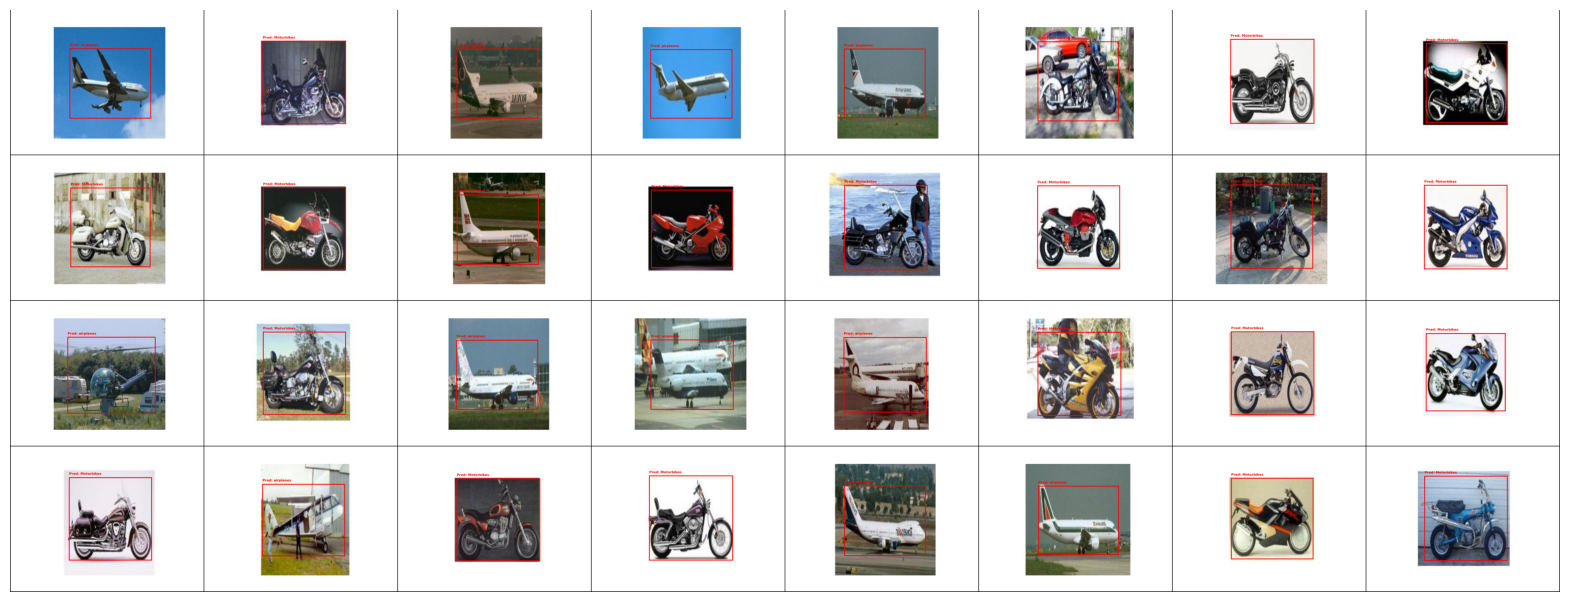

In [12]:
plt.figure(figsize=(20, 20))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()

In [13]:
plt.imsave("assets/vit_detection.png", grid.permute(1, 2, 0).numpy())